In [ ]:
!pip install keras_preprocessing
!pip install keras_applications
# Most Recent One (Suggested)
!pip install git+https://github.com/rcmalli/keras-vggface.git
# Release Version
!pip install keras_vggface
# !pip install opencv-python-headless

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model
from keras_vggface.vggface import VGGFace

from PIL import Image
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras_preprocessing import image as keras_image
from keras.utils import to_categorical
from keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras_vggface import utils

# from google.cloud import storage
import numpy as np
import cv2
import io

# display maximum width of columns
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)

print(keras.__version__)

2.12.0


### Data Preprocessing

-  Load the label data


In [3]:
# Load the Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive/')
path_gdrive = '/content/drive/MyDrive/Machine Learning/MLcode/Final Project'
os.chdir(path_gdrive)
print(os.getcwd())

Mounted at /content/drive/
/content/drive/MyDrive/Machine Learning/MLcode/Final Project


In [ ]:
# # Check if the file is located in the correct directory
# print(os.listdir('c:/Users/Richa/MLcode/final/BMI/BMI/Data/'))

['.DS_Store', 'data.csv', 'Images']


In [4]:
# Read the label file
df_label = pd.read_csv('./BMI/BMI/Data/data.csv')
# change the first column name to id
df_label.rename(columns={'Unnamed: 0':'id'}, inplace=True)
# add a new column to indicate the category of BMI
df_label['bmi_category'] = pd.cut(df_label['bmi'], bins=[16, 18.5, 25, 30, 35, 40, 100], labels=['underweight', 'normal', 'overweight', 'moderately obese', 'severely obese', 'very severely obese'])

df_label.head()


,id,bmi,gender,is_training,name,bmi_category
0,0,34.207396,Male,1,img_0.bmp,moderately obese
1,1,26.453720,Male,1,img_1.bmp,overweight
2,2,34.967561,Female,1,img_2.bmp,moderately obese
3,3,22.044766,Female,1,img_3.bmp,normal
4,4,37.758789,Female,1,img_4.bmp,severely obese


- Load the image data

In [5]:
# Load data
data_df = df_label.copy()
# split the data into training and test set
training_set = data_df[data_df['is_training'] == 1]
test_set = data_df[data_df['is_training'] == 0]

In [ ]:
training_set

,id,bmi,gender,is_training,name,bmi_category
0,0,34.207396,Male,1,img_0.bmp,moderately obese
1,1,26.453720,Male,1,img_1.bmp,overweight
2,2,34.967561,Female,1,img_2.bmp,moderately obese
3,3,22.044766,Female,1,img_3.bmp,normal
4,4,37.758789,Female,1,img_4.bmp,severely obese
...,...,...,...,...,...,...
3363,3363,22.128772,Female,1,img_3363.bmp,normal
3364,3364,38.770270,Male,1,img_3364.bmp,severely obese
3365,3365,31.581081,Male,1,img_3365.bmp,moderately obese
3366,3366,29.049587,Female,1,img_3366.bmp,overweight


In [ ]:
img_dir = './BMI/BMI/Data/Images'

def load_image_kimage(img_dir):
    # Load the image file
    img = keras_image.load_img(img_dir, target_size=(224, 224))
    x = keras_image.img_to_array(img)
    x = preprocess_input(x)
    return x

# Initialize empty lists to store the images and existing image names
images_kimage = []
existing_images = []

# Iterate over the file names
for fname in data_df['name']:
    img_path = os.path.join(img_dir, fname)
    
    # Check if the file exists
    if os.path.exists(img_path):
        # If the file exists, load the image and append it to the lists
        images_kimage.append(load_image_kimage(img_path))
        existing_images.append(fname)

# Create a new DataFrame with the existing image information
existing_images_df = data_df[data_df['name'].isin(existing_images)].copy()
existing_images_df['image'] = images_kimage

# Split into train and test sets based on the 'is_training' column
train_df = existing_images_df[existing_images_df['is_training'] == 1]
test_df = existing_images_df[existing_images_df['is_training'] == 0]

# Convert the 'image' column to a numpy array
train_images = np.array(train_df['image'].tolist())
test_images = np.array(test_df['image'].tolist())

# Verify the shape of the train and test DataFrames
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Train shape: (3210, 7)
Test shape: (752, 7)


In [ ]:
import numpy as np

# Save existing_images_df to CSV
existing_images_df.to_csv('existing_images_df.csv', index=False)

# Save train_images and test_images to .npy files
np.save('train_images.npy', train_images)
np.save('test_images.npy', test_images)

print("Files saved successfully.")


Files saved successfully.


In [6]:
train_images = np.load('train_images.npy')
test_images = np.load('test_images.npy')

In [7]:
# extract the y_train, exclude the images that are not in the training set
y_train = []
img_dir = './BMI/BMI/Data/Images'
train_set = data_df[data_df['is_training'] == 1]
for name in train_set['name']:
    img_path = os.path.join(img_dir, name)
    if os.path.exists(img_path):
        y_train.append(train_set.loc[train_set['name'] == name, 'bmi'].iloc[0])
y_train = np.array(y_train)

In [8]:
# extract the y_test, exclude the images that are not in the test set
y_test = []
img_dir = './BMI/BMI/Data/Images'
test_set = data_df[data_df['is_training'] == 0]
for name in test_set['name']:
    img_path = os.path.join(img_dir, name)
    if os.path.exists(img_path):
        y_test.append(test_set.loc[test_set['name'] == name, 'bmi'].iloc[0])
y_test = np.array(y_test)

In [9]:
# print the shape of y_train and y_test
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

y_train shape: (3210,)
y_test shape: (752,)


## Feature Extraction using VGG resnet50 model

In this section, we will use the pretrained VGG resnet50 model to extract features from the images. The features will be used to train the SVR model.

In [10]:
# split the data into training and validation sets by 'is_training' column
train_df = data_df[data_df['is_training'] == 1]
val_df = data_df[data_df['is_training'] == 0]

# print the shape of the training and validation sets
print(train_df.shape)
print(val_df.shape)

(3368, 6)
(838, 6)


In [ ]:
# image directory
img_dir = './BMI/BMI/Data/Images'

# Create a VGGFace model with the ResNet50 architecture, without the final fully connected layer
resnet50_model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3))

# Get the output of the "avg_pool" layer
avg_pool_output = resnet50_model.get_layer("avg_pool").output

# Create a new model that outputs the features from the "avg_pool" layer
vgg_resnet50 = Model(inputs=resnet50_model.input, outputs=avg_pool_output)

# Compile the feature extraction model (optional, as it won't be trained)
vgg_resnet50.compile()

# Batch size for processing images
batch_size = 32
X_train_resnet50 = []


In [ ]:
# Iterate over images in batches
for i in range(0, len(training_set), batch_size):
    batch_paths = [os.path.join(img_dir, name) for name in training_set['name'][i:i+batch_size]]
    batch_images = []

 # Load and preprocess batch of images
    for path in batch_paths:
        if os.path.exists(path):
            img = keras_image.load_img(path, target_size=(224, 224))
            x = keras_image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            batch_images.append(x)
        else:
            None
    if len(batch_images) > 0:
        batch_images = np.vstack(batch_images)
        batch_features = vgg_resnet50.predict(batch_images)
        batch_features = batch_features.reshape(len(batch_images), -1)
        X_train_resnet50.append(batch_features)

# Concatenate features from all batches
X_train_resnet50 = np.concatenate(X_train_resnet50, axis=0)

1/1 [==============================] - 1s 623ms/step


In [ ]:
# store the extracted features in a .npy file
np.save('X_train_resnet50.npy', X_train_resnet50)

In [ ]:
# Iterate over images in batches to extract features

# Batch size for processing images
batch_size = 32
X_test_resnet50 = []

for i in range(0, len(test_set), batch_size):
    batch_paths = [os.path.join(img_dir, name) for name in test_set['name'][i:i+batch_size]]
    batch_images = []

 # Load and preprocess batch of images
    for path in batch_paths:
        if os.path.exists(path):
            img = keras_image.load_img(path, target_size=(224, 224))
            x = keras_image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            batch_images.append(x)
        else:
            None
    if len(batch_images) > 0:
        batch_images = np.vstack(batch_images)
        batch_features = vgg_resnet50.predict(batch_images)
        batch_features = batch_features.reshape(len(batch_images), -1)
        X_test_resnet50.append(batch_features)

# Concatenate features from all batches
X_test_resnet50 = np.concatenate(X_test_resnet50, axis=0)

1/1 [==============================] - 1s 658ms/step


In [ ]:
# store the extracted features in a .npy file
np.save('X_test_resnet50.npy', X_test_resnet50)

In [11]:
X_train_resnet50 = np.load('X_train_resnet50.npy')
X_test_resnet50 = np.load('X_test_resnet50.npy')

print(f'shape of X_train_resnet50: {X_train_resnet50.shape}')
print(f'shape of X_test_resnet50: {X_test_resnet50.shape}')


shape of X_train_resnet50: (3210, 2048)
shape of X_test_resnet50: (752, 2048)


In [12]:
# Train the SVR model
from sklearn.svm import SVR
regressor = SVR(epsilon=0.2)
regressor.fit(X_train_resnet50,y_train)

SVR(epsilon=0.2)

In [13]:
y_pred = regressor.predict(X_test_resnet50)

In [30]:
# Evaluate the model

# import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Mean squared error:', mse)
print("Root Mean Squared Error", np.sqrt(mean_squared_error(y_test, y_pred)))
print('Mean absolute error:', mae)
print('R-squared:', r2)
print("Correlation Coefficient: ", np.corrcoef(y_pred, y_test)[0,1])

Mean squared error: 54.550460112273655
Root Mean Squared Error 7.385828329461337
Mean absolute error: 5.177273173273857
R-squared: 0.3574196815544025
Correlation Coefficient:  0.6516278157327181


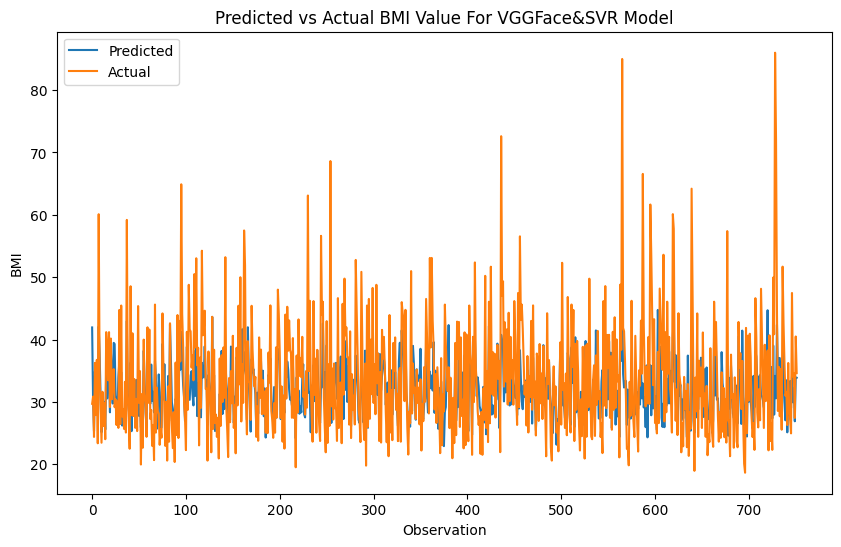

In [21]:
# plot the predicted BMI Value
plt.figure(figsize=(10, 6))
plt.plot(y_pred, label='Predicted')
plt.plot(y_test, label='Actual')
plt.title('Predicted vs Actual BMI Value For VGGFace&SVR Model')
plt.xlabel('Observation')
plt.ylabel('BMI')
plt.legend()
plt.show()

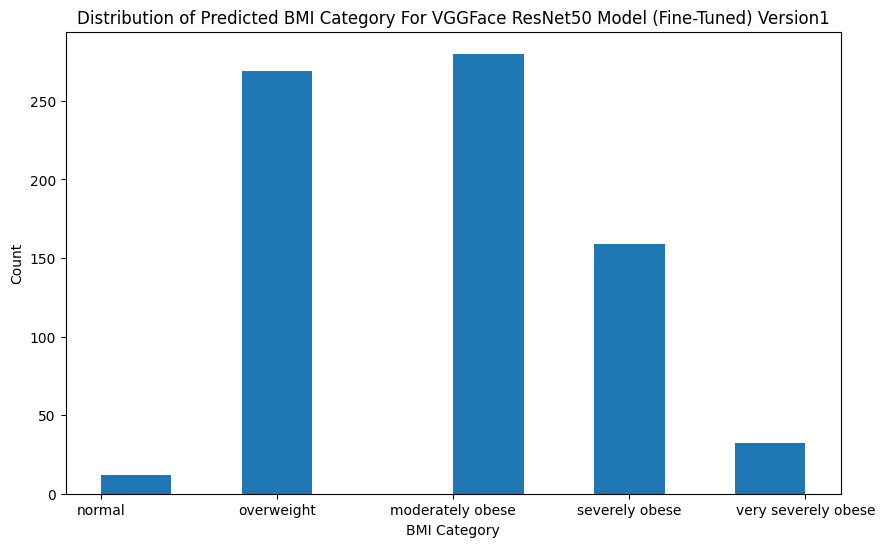

In [18]:
# sort the predicted BMI Value
y_pred_sorted = np.sort(y_pred, axis=0)
y_pred_sorted = y_pred_sorted.reshape(-1, 1)
# create a DataFrame with the associated BMI Category for each predicted BMI Value, underweight: (16 < BMI ≤ 18.5), normal (18.5 < BMI ≤ 25), overweight (25 < BMI ≤ 30), moderately obese (30 < BMI ≤ 35), severely obese (35 < BMI ≤ 40) and severely obese(40 < BMI)
df_pred = pd.DataFrame(y_pred_sorted, columns=['bmi'])
def bmi_category(bmi):
    if bmi <= 18.5:
        return 'underweight'
    elif bmi <= 25:
        return 'normal'
    elif bmi <= 30:
        return 'overweight'
    elif bmi <= 35:
        return 'moderately obese'
    elif bmi <= 40:
        return 'severely obese'
    else:
        return 'very severely obese'
    
df_pred['bmi_category'] = df_pred['bmi'].apply(bmi_category)

# plot the distribution of the predicted BMI Category, using histogram, add title and labels, keep the ditance between each category bar same
plt.figure(figsize=(10, 6))
plt.hist(df_pred['bmi_category'])
plt.title('Distribution of Predicted BMI Category For VGGFace&SVR Model')
plt.xlabel('BMI Category')
plt.ylabel('Count')
plt.show()

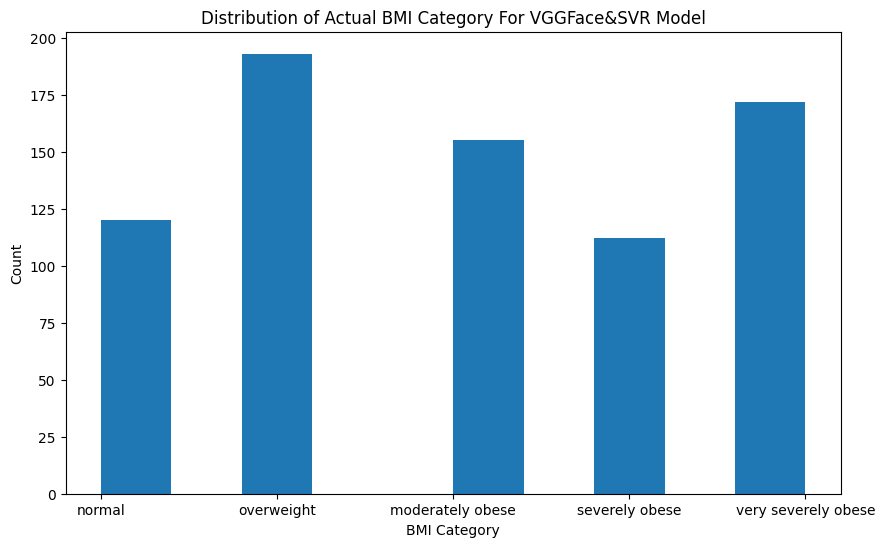

In [25]:
# sort the test_generated labels and create a DataFrame with the associated BMI Category for each test_generated label
y_test_sorted = np.sort(y_test, axis=0)
y_test_sorted = y_test_sorted.reshape(-1, 1)
df_y_test_sorted = pd.DataFrame(y_test_sorted, columns=['bmi'])

df_y_test_sorted['bmi_category'] = df_y_test_sorted['bmi'].apply(bmi_category)

# plot the distribution of the test_generated BMI Category, using histogram, add title and labels
plt.figure(figsize=(10, 6))
plt.hist(df_y_test_sorted['bmi_category'])
plt.title('Distribution of Actual BMI Category For VGGFace&SVR Model')
plt.xlabel('BMI Category')
plt.ylabel('Count')
plt.show()